# Cassava Leaf Disease Classification

Identify the type of disease present on a Cassava Leaf image

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Recommended Tutorial**
We highly recommend [Jesse Mostipak’s Getting Started Tutorial](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) that walks you through making your very first submission step by step.

Link: https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

Help

* https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training 
* https://www.kaggle.com/japandata509/ensemble-resnext50-32x4d-efficientnet-0-903

In [1]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
train_df = pd.read_csv("../../data/cassava-leaf-disease-classification/train.csv")
train_df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


<IPython.core.display.Javascript object>

In [4]:
train_df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
labels = pd.read_json(
    "../../data/cassava-leaf-disease-classification/label_num_to_disease_map.json",
    orient="index",
)
labels.columns = ["Name"]
labels

,Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<IPython.core.display.Javascript object>

# Подготовка датасетов

In [6]:
class CassavaDataset(Dataset):
    """
    see: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    def __init__(self, data_frame, image_dir, transform=None):
        self.cassava_frame = data_frame
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.cassava_frame)

    def __getitem__(self, idx):
        image_id, label = self.cassava_frame.iloc[idx]

        image_path = os.path.join(self.image_dir, image_id)
        # image = read_image(image_path)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, image_id, label

    def get_transform(step=None, size=512):
        if step == "train":
            return A.Compose(
                [
                    A.Resize(size, size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ToTensorV2(),
                ]
            )

        return A.Compose(
            [
                A.Resize(size, size),
                A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )

<IPython.core.display.Javascript object>

In [7]:
X_train, X_test = train_test_split(train_df, test_size=0.1)
X_train, X_val = train_test_split(X_train, test_size=0.1)

X_train.shape, X_test.shape, X_val.shape

((17331, 2), (2140, 2), (1926, 2))

<IPython.core.display.Javascript object>

In [8]:
IMAGE_DIR = "../../data/cassava-leaf-disease-classification/train_images"

train_dataset = CassavaDataset(
    data_frame=X_train,
    image_dir=IMAGE_DIR,
    transform=CassavaDataset.get_transform("train"),
)

val_dataset = CassavaDataset(
    data_frame=X_val, image_dir=IMAGE_DIR, transform=CassavaDataset.get_transform()
)

test_dataset = CassavaDataset(
    data_frame=X_test, image_dir=IMAGE_DIR, transform=CassavaDataset.get_transform()
)

len(train_dataset), len(val_dataset), len(test_dataset)

(17331, 1926, 2140)

<IPython.core.display.Javascript object>

# Визуальное отображение заболеваний

In [9]:
def draw_images(sub_frame, title=None):
    draw_dataset = CassavaDataset(
        data_frame=sub_frame, image_dir=IMAGE_DIR, transform=None,
    )

    figure = plt.figure(figsize=(14, 5))
    if title:
        figure.suptitle(title, fontsize=16)

    rows, cols = 2, 4
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(draw_dataset), size=(1,)).item()
        image, image_id, label = draw_dataset[sample_idx]

        figure.add_subplot(rows, cols, i)
        plt.title(image_id)
        plt.axis("off")
        plt.imshow(image, cmap="gray")
    plt.show()

<IPython.core.display.Javascript object>

In [10]:
labels

,Name
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<IPython.core.display.Javascript object>

## Cassava Bacterial Blight (CBB)

Xanthomonas axonopodis pv. manihotis - возбудитель, вызывающий **бактериальный ожог маниоки** . Заболевание, впервые обнаруженное в Бразилии в 1912 году, распространилось по всему миру после выращивания маниоки. Среди болезней, поражающих маниоку во всем мире, бактериальный ожог вызывает наибольшие потери урожая.

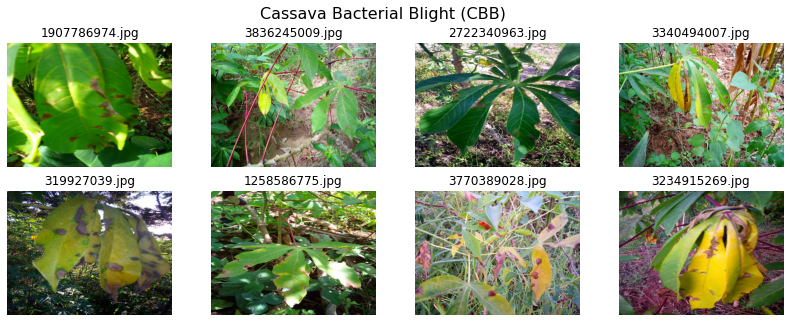

<IPython.core.display.Javascript object>

In [11]:
sub_df = train_df[train_df["label"] == 0]
draw_images(sub_df, title="Cassava Bacterial Blight (CBB)")

## Cassava Brown Streak Disease (CBSD)

Болезнь вируса коричневой полосы кассавы является разрушительной болезнью растений маниоки и особенно опасна в Восточной Африке. Впервые он был обнаружен в 1936 году в Танзании и распространился в другие прибрежные районы Восточной Африки, от Кении до Мозамбика.

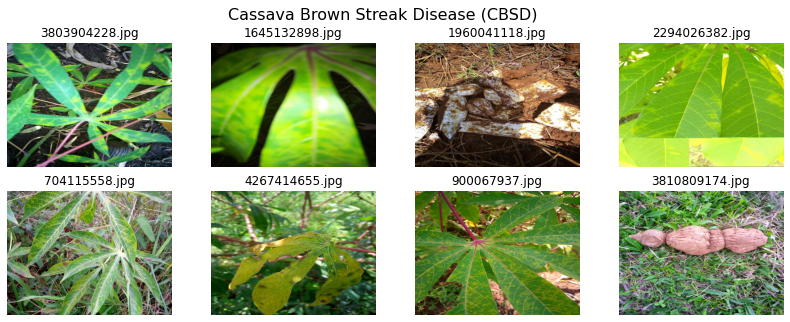

<IPython.core.display.Javascript object>

In [12]:
sub_df = train_df[train_df["label"] == 1]
draw_images(sub_df, title="Cassava Brown Streak Disease (CBSD)")

## Cassava Green Mottle (CGM)

Вирус зеленой крапивы маниоки - это растительный патогенный вирус семейства Secoviridae.

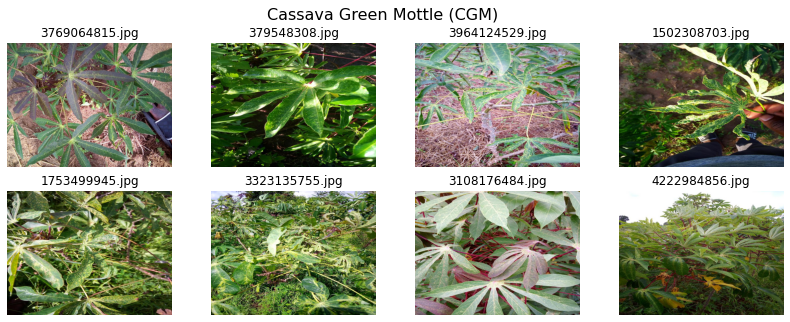

<IPython.core.display.Javascript object>

In [13]:
sub_df = train_df[train_df["label"] == 2]
draw_images(sub_df, title="Cassava Green Mottle (CGM)")

## Cassava Mosaic Disease (CMD)

Вирус мозаики африканской маниоки - это растительный патогенный вирус семейства Geminiviridae, который может вызывать либо мозаичное появление листьев растений, либо хлороз - потерю хлорофилла. В Manihot esculenta, очень ценной африканской продовольственной культуре, вирус вызывает серьезную мозаику.

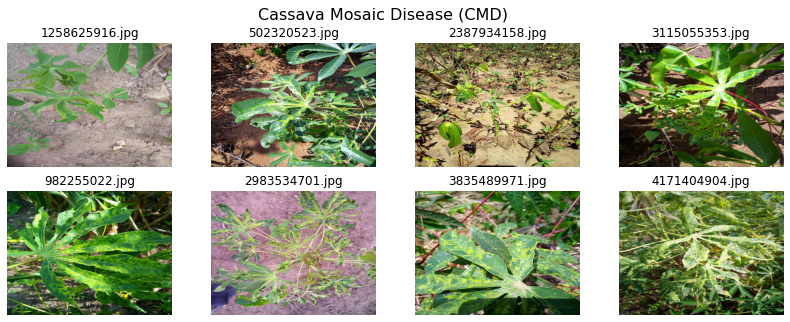

<IPython.core.display.Javascript object>

In [14]:
sub_df = train_df[train_df["label"] == 3]
draw_images(sub_df, title="Cassava Mosaic Disease (CMD)")

## Healthy

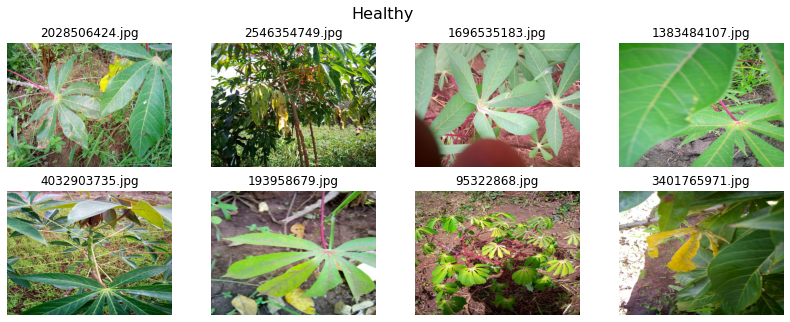

<IPython.core.display.Javascript object>

In [15]:
sub_df = train_df[train_df["label"] == 4]
draw_images(sub_df, title="Healthy")

# Подготовка и обучение моделей

In [16]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

len(train_loader), len(val_loader), len(test_loader)

(2166, 241, 268)

<IPython.core.display.Javascript object>

In [17]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

<IPython.core.display.Javascript object>

In [18]:
class CassavaClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/vision/stable/models.html#classification
        # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
        self.model = models.resnext50_32x4d(weights=None)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 5)

    def forward(self, x):
        x = self.model(x)
        return x

<IPython.core.display.Javascript object>

In [19]:
model = CassavaClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6,amsgrad=False)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
)

<IPython.core.display.Javascript object>

In [20]:
def step_score(model, loader, desc=""):
    model.eval()

    step_accuracy = 0

    pbar = tqdm(enumerate(loader), total=len(loader))
    if desc:
        pbar.set_description(desc)

    for _, (images, image_ids, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)

        y_pred = y_preds.argmax(dim=1).cpu().detach().numpy()
        y_true = labels.cpu().detach().numpy()

        step_accuracy += (y_pred == y_true).mean()

    return step_accuracy / len(loader)

<IPython.core.display.Javascript object>

In [21]:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# .. https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description("Epoch %d" % epoch)

    epoch_loss = 0
    epoch_accuracy = 0

    for _, (images, image_ids, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        loss = loss_fn(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = y_preds.argmax(dim=1).cpu().detach().numpy()
        y_true = labels.cpu().detach().numpy()

        epoch_loss += loss.cpu().detach().numpy()
        epoch_accuracy += (y_pred == y_true).mean()

    scheduler.step()

    print(
        "Loss: {}, Train accuracy: {}, Val accuracy: {}".format(
            epoch_loss / len(train_loader),
            epoch_accuracy / len(train_loader),
            step_score(model, val_loader, "Validation"),
        )
    )

  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 1.1090536334535532, Train accuracy: 0.617786241920591, Val accuracy: 0.4847856154910097


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 1.0293932661950753, Train accuracy: 0.6299053554939982, Val accuracy: 0.6519709543568465


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.9378861904570821, Train accuracy: 0.6532779316712835, Val accuracy: 0.6441908713692946


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.8484513917705689, Train accuracy: 0.6834025854108957, Val accuracy: 0.7050484094052558


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.778580639800289, Train accuracy: 0.7101800554016621, Val accuracy: 0.7472337482710927


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.7107518890275795, Train accuracy: 0.7385156971375808, Val accuracy: 0.7261410788381742


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.6553244091233278, Train accuracy: 0.7599838411819021, Val accuracy: 0.776625172890733


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.6065648636803898, Train accuracy: 0.7781625115420129, Val accuracy: 0.7892461964038728


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.5708187458364229, Train accuracy: 0.7940904893813481, Val accuracy: 0.7949515905947442


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.5471941667143685, Train accuracy: 0.803612650046168, Val accuracy: 0.7954702627939143


<IPython.core.display.Javascript object>

## Проверка результатов

In [22]:
test_accuracy = step_score(model, test_loader, "Testing")
test_accuracy

  0%|          | 0/268 [00:00<?, ?it/s]

0.8208955223880597

<IPython.core.display.Javascript object>